In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
from pathlib import Path
import awkward as ak
import seaborn as sn
from fast_histogram import histogram2d

In [2]:
datapath = Path("/disk/atlas3/data_MC/topTagging/top")

The dataset is the top tagging reference dataset:
https://docs.google.com/document/d/1Hcuc6LBxZNX16zjEGeq16DAzspkDC4nDTyjMp1bWHRo/edit


In [3]:
def load_array(path:Path):
    with h5py.File(path) as f:
        labels = ["event_id", "clusters", "truth_jet", "ttv", "is_signal"]
        data = f["table"]["table"] #dataset, each row is a void type
        print(data.dtype)
        eventid, clusters, misc = data['index'], data['values_block_0'], data['values_block_1']
        truthjets = clusters[:,-4:]
        clusters = clusters[:,:-4]
        clusters = np.transpose(clusters.reshape(len(clusters), 200, 4), (2, 0, 1))
        
        print(clusters.shape)
        cluster_labels = ["E", "x", "y", "z"]
        cluster_arr = ak.Array(dict(zip(cluster_labels, clusters)))
        
        arr = ak.Array(dict(zip(labels, [eventid, cluster_arr, truthjets, misc[:,0], misc[:,1]])))
        return arr

def cal_image_plot(ax):
    ax.set_ylabel(r"$\phi$ [radians]]", fontsize=16)
    ax.set_xlabel(r"$\eta$", fontsize=16)
    #ax.set_title("Calorimeter image", fontsize=20, color="black")
    ax.tick_params(which="both", direction="inout", top=True, right=True, labelsize=14, pad=15, length=4, width=2)
    ax.tick_params(which="major", length=8)
    ax.tick_params(which="major", length=6)
    ax.minorticks_on()

def zero_to_nan(arr):
    clusters = arr.clusters
    clusters.E = ak.where(clusters.E == 0, np.nan, clusters.E)
    clusters.x = ak.where(clusters.x == 0, np.nan, clusters.x)
    clusters.y = ak.where(clusters.y == 0, np.nan, clusters.y)
    clusters.z = ak.where(clusters.z == 0, np.nan, clusters.z)
    arr.clusters = clusters
    return arr

def cartesian_to_angles(arr, drop:bool=False):
    clusters = arr.clusters
    clusters["pT"] = np.sqrt(clusters.x**2 + clusters.y**2)
    clusters["eta"] = np.arcsinh(clusters.z/clusters["pT"])
    clusters["phi"] = np.arcsin(clusters.y/clusters["pT"])
    """
    Add this functionality
    if drop:
    """
    arr.clusters = clusters
    return arr

In [4]:
train = load_array(datapath/'train.h5')

[('index', '<i8'), ('values_block_0', '<f4', (804,)), ('values_block_1', '<i8', (2,))]
(4, 1211000, 200)


In [7]:
signal, bkg = train[train.is_signal==1], train[train.is_signal==0]
signal, bkg = zero_to_nan(signal), zero_to_nan(bkg)
signal, bkg = cartesian_to_angles(signal), cartesian_to_angles(bkg)
print(len(signal), len(bkg))

605477 605523


In [9]:
signal_eta = ak.to_list(signal.clusters.eta[:,0])
signal_phi = ak.to_list(signal.clusters.phi[:,0])
signal_E = ak.to_list(signal.clusters.E[:,0])

bkg_eta = ak.to_list(bkg.clusters.eta[:,0])
bkg_phi = ak.to_list(bkg.clusters.phi[:,0])
bkg_E = ak.to_list(bkg.clusters.E[:,0])


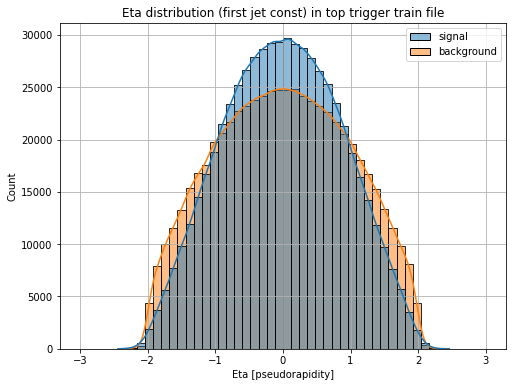

In [10]:
fig, ax = plt.subplots(figsize=(8,6))
sn.histplot({"signal": signal_eta, "background": bkg_eta}, ax = ax, bins=50, binrange=[-3,3], kde=True, multiple="layer")
ax.set_title("Eta distribution (first jet const) in top trigger train file")
ax.set_xlabel("Eta [pseudorapidity]")
#ax.set_yscale('log')
ax.grid(visible=None)

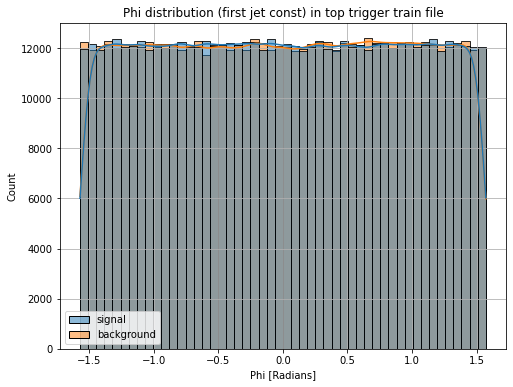

In [11]:
fig, ax = plt.subplots(figsize=(8,6))
sn.histplot({"signal": signal_phi, "background": bkg_phi}, ax = ax, bins=50, kde=True)
ax.set_title("Phi distribution (first jet const) in top trigger train file")
ax.set_xlabel("Phi [Radians]")
#ax.set_yscale('log')
ax.grid(visible=None)

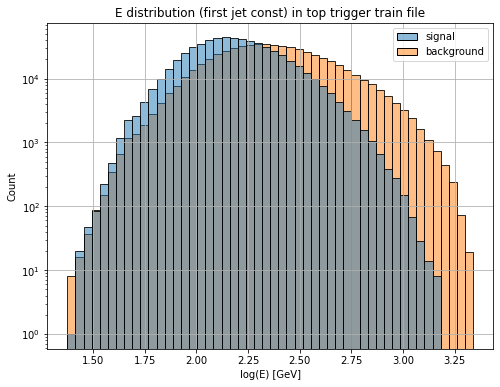

In [22]:
fig, ax = plt.subplots(figsize=(8,6))
sn.histplot({"signal": np.log10(signal_E), "background": np.log10(bkg_E)}, ax = ax, bins=50)
ax.set_title("E distribution (first jet const) in top trigger train file")
ax.set_xlabel("log(E) [GeV]")
ax.set_yscale('log')
#ax.set_xscale('log')
ax.grid(visible=None)

In [26]:
MAX_EVENTS = 100
RESOLUTION = 80

def create_histograms(array):
    max_available_events = len(array)
    if max_available_events < MAX_EVENTS:
        max_events = max_available_events
    else: max_events = MAX_EVENTS
    #Cal = [histogram2d(event.phi, event.eta, range=[[-np.pi, np.pi], [-2.5, 2.5]], bins=RESOLUTION, weights=event.pT) for event in array[:max_events]]
    Cal = [histogram2d(event.phi, event.eta, range=[[-np.pi, np.pi], [-2.5, 2.5]], bins=RESOLUTION) for event in array[:max_events]]
    return Cal
    
signal_hists = create_histograms(signal.clusters)
bkg_hists = create_histograms(bkg.clusters)

## Signal images (non weighted)

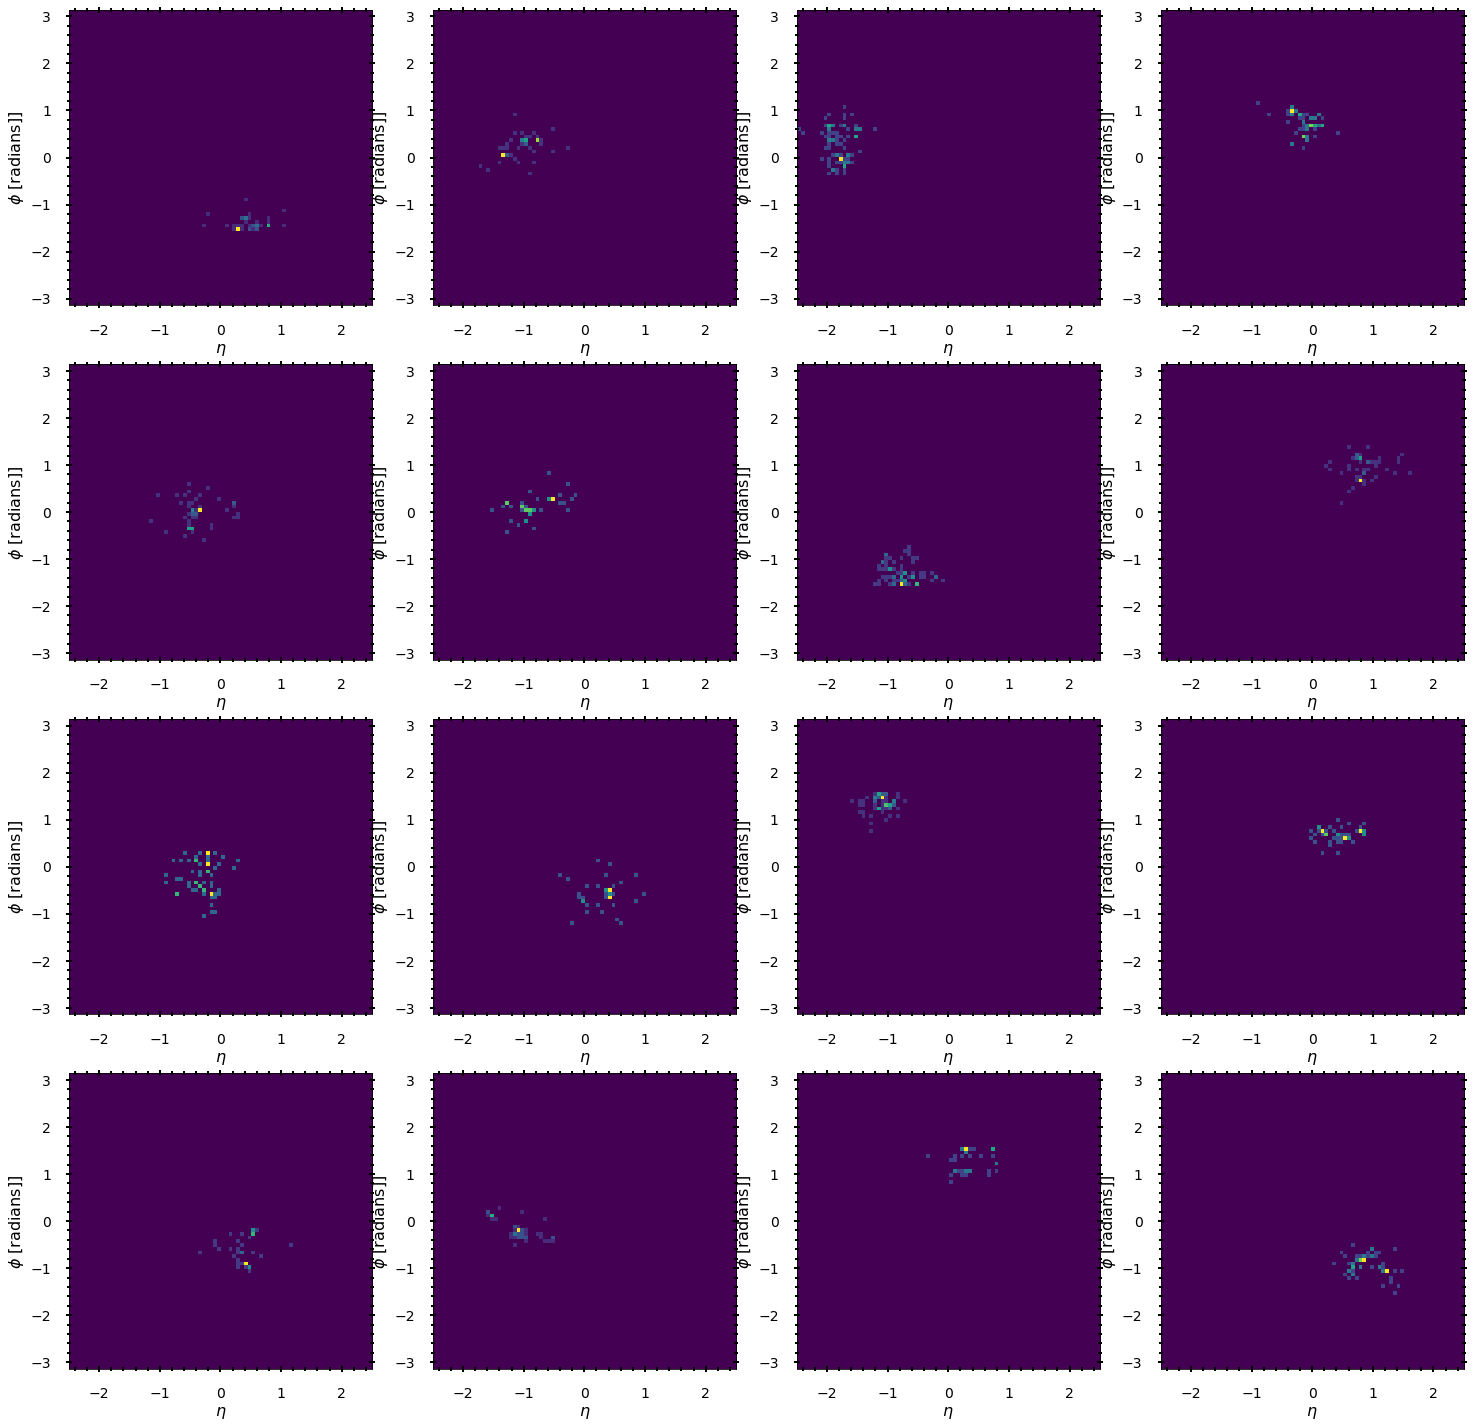

In [27]:
fig, axs = plt.subplots(nrows = 4, ncols = 4, figsize = (25,25))
images = np.random.randint(0, high=len(signal_hists), size=(4,4))
for i in range(4):
    for j in range(4):
        cal_image_plot(axs[i][j])
        axs[i][j].imshow(signal_hists[images[i][j]], extent=[-2.5, 2.5, -np.pi, np.pi], aspect='auto')

## Background images (non weighted)

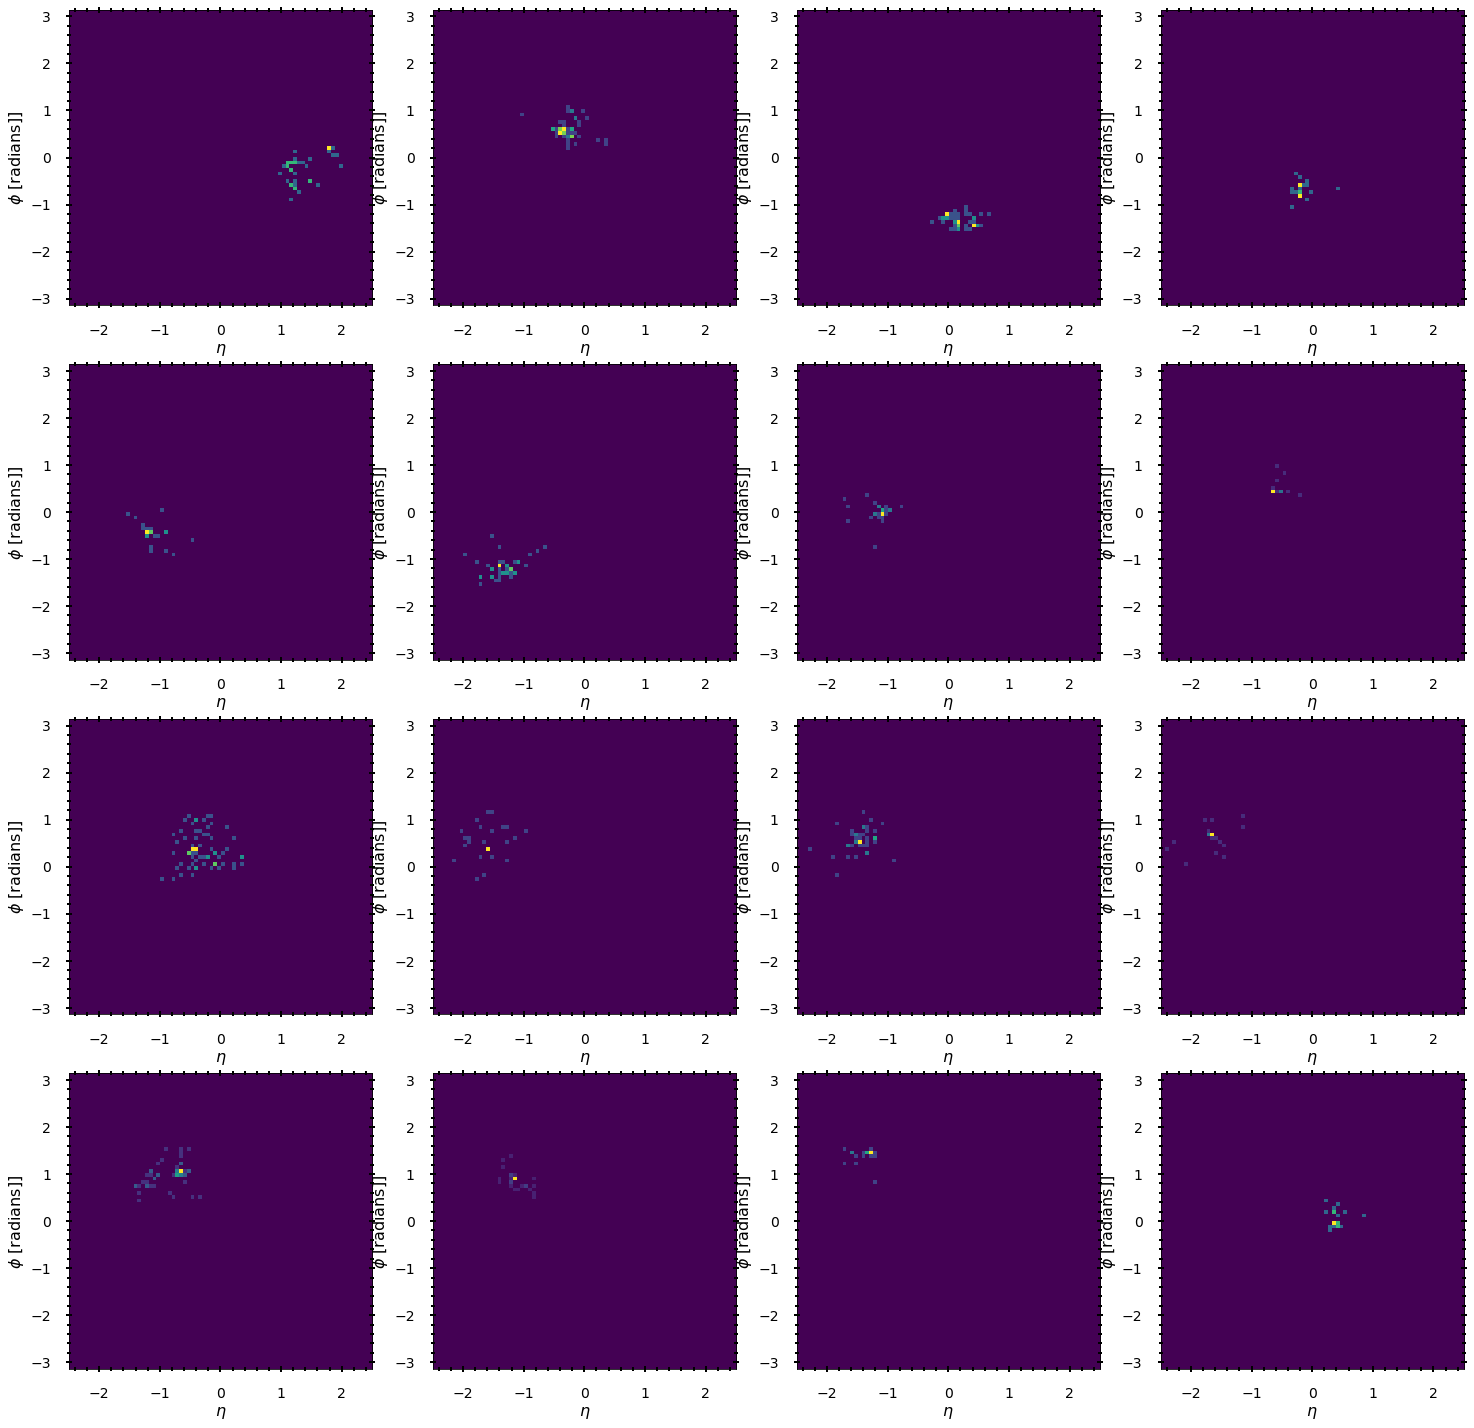

In [28]:
fig, axs = plt.subplots(nrows = 4, ncols = 4, figsize = (25,25))
images = np.random.randint(0, high=len(bkg_hists), size=(4,4))
for i in range(4):
    for j in range(4):
        cal_image_plot(axs[i][j])
        axs[i][j].imshow(bkg_hists[images[i][j]], extent=[-2.5, 2.5, -np.pi, np.pi], aspect='auto')
